# 01-clean-data

## Main Objectives

- Dataset inspection and sanity checking
- Basic function based cleaning
- SpaCy based cleaning and normalization
- Saving cleaned dataset for subsequent notebooks


In [ ]:
!ls
##!python -m spacy download en_core_web_lg

In [14]:
!ls
!wget https://s3.amazonaws.com/fast-ai-nlp/yelp_review_polarity_csv.tgz -O yelp_review_polarity_csv.tgz
!tar xzvf yelp_review_polarity_csv.tgz

score.png		  yelp_reviews_stars.ipynb  yelp_train_df.csv
yelp_review_polarity_csv  yelp_test_df.csv
--2021-03-15 22:08:12--  https://s3.amazonaws.com/fast-ai-nlp/yelp_review_polarity_csv.tgz
Resolving s3.amazonaws.com... 52.217.18.254
Connecting to s3.amazonaws.com|52.217.18.254|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 166373201 (159M) [application/x-tar]
Saving to: ‘yelp_review_polarity_csv.tgz’

yelp_review_polarit 100%[===================>] 158.67M  20.5MB/s    in 8.3s    

2021-03-15 22:08:26 (19.0 MB/s) - ‘yelp_review_polarity_csv.tgz’ saved [166373201/166373201]

yelp_review_polarity_csv/
yelp_review_polarity_csv/train.csv
yelp_review_polarity_csv/readme.txt
yelp_review_polarity_csv/test.csv


In [1]:
import pandas as pd
import numpy as np
import spacy
import re
import string
from spacy.lang.en.examples import sentences 
from spacy import displacy
from spacy.util import minibatch, compounding
from bs4 import BeautifulSoup
from nltk.tokenize import RegexpTokenizer

import nltk

import matplotlib.pyplot as plt
%matplotlib inline

## Load raw data, verify size of both sets (training and test)

- We should have 560,000 rows for training and 38,000 rows for test/validation
- Use head() to take a look at the current format

In [2]:
data_names=['Score', 'Raw']
yelp_test_df=pd.read_csv('yelp_review_polarity_csv/test.csv', names=data_names)
yelp_train_df=pd.read_csv('yelp_review_polarity_csv/train.csv', names=data_names)

print('training data set size:')
print(yelp_train_df.shape)
print('test data set size:')
print(yelp_test_df.shape)

training data set size:
(560000, 2)
test data set size:
(38000, 2)


In [16]:
yelp_train_df.head()

,Score,Raw
0,1,"Unfortunately, the frustration of being Dr. Go..."
1,2,Been going to Dr. Goldberg for over 10 years. ...
2,1,I don't know what Dr. Goldberg was like before...
3,1,I'm writing this review to give you a heads up...
4,2,All the food is great here. But the best thing...


# Clean Up Pass #1

Rudimentary function based text cleaning

- remove extra new line characters
- remove some special characters
- for later datasets (commented out for now), remove punctuation and more special characters

In [17]:
def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    text = re.sub(pattern, '', text)
    return text

def normalize_corpus(corpus):
  normalized_corpus = []
  for doc in corpus:
    #doc = doc.lower()
    doc = re.sub(r'[\r|\n|\r\n]+', ' ',doc)
    doc = re.sub('\\\\n',' ',doc)
    special_char_pattern = re.compile(r'([{.(-)!}])')
    #doc = special_char_pattern.sub(" \\1 ", doc)
    #doc = remove_special_characters(doc, remove_digits=True)  
    doc = re.sub(' +', ' ', doc)
    normalized_corpus.append(doc)

  return normalized_corpus

## Test on a sample review or two to verify cleaning functions

In [ ]:
test = []
print(yelp_train_df['Raw'][90])
test.append(yelp_train_df['Raw'][90])
print(yelp_train_df['Raw'][40])
test.append(yelp_train_df['Raw'][40])
test_clean = normalize_corpus(test)
print(test_clean[0])
print(test_clean[1])

## Save our first pass clean in our dataframe under 'Clean'

In [20]:
yelp_test_df['Clean'] = normalize_corpus(yelp_test_df['Raw'])
yelp_train_df['Clean'] = normalize_corpus(yelp_train_df['Raw'])

# Clean Up Pass #2
Using SpaCy, remove stop works, lemmatize, lowercase, strip extra spaces and remove punctuation.  Only keep tokens identified as '-PRON-'

In [3]:
spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS
print('Number of stop words: %d' % len(spacy_stopwords))
print('First ten stop words: %s' % list(spacy_stopwords)[:10])

Number of stop words: 326
First ten stop words: ['upon', 'do', 'her', 'also', 'seems', 'among', 'behind', 'he', 'take', 'whole']


In [6]:
nlp = spacy.load('en_core_web_sm')
nlp.pipe_names
punctuations = string.punctuation

def cleanup_nlp_text(docs, logging=False):
  texts = []
  counter = 1
  for doc in docs:
    if counter % 10000 == 0 and logging:
      print("%d out of %d" % (counter, len(docs)))
    counter += 1
    doc = nlp(doc, disable=['parser', 'ner'])
    tokens = [tok.lemma_.lower().strip() for tok in doc if tok.lemma_ != '-PRON-']
    tokens = [tok for tok in tokens if tok not in spacy_stopwords and tok not in punctuations]
    tokens = ' '.join(tokens)
    texts.append(tokens)
  return pd.Series(texts)

## Apply SpaCy cleanup_nlp_text to the 'Clean' dataset from Pass #1

In [23]:
yelp_test_df['Text'] = cleanup_nlp_text(yelp_test_df['Clean'], True)

1000 out of 38000
2000 out of 38000
3000 out of 38000
4000 out of 38000
5000 out of 38000
6000 out of 38000
7000 out of 38000
8000 out of 38000
9000 out of 38000
10000 out of 38000
11000 out of 38000
12000 out of 38000
13000 out of 38000
14000 out of 38000
15000 out of 38000
16000 out of 38000
17000 out of 38000
18000 out of 38000
19000 out of 38000
20000 out of 38000
21000 out of 38000
22000 out of 38000
23000 out of 38000
24000 out of 38000
25000 out of 38000
26000 out of 38000
27000 out of 38000
28000 out of 38000
29000 out of 38000
30000 out of 38000
31000 out of 38000
32000 out of 38000
33000 out of 38000
34000 out of 38000
35000 out of 38000
36000 out of 38000
37000 out of 38000
38000 out of 38000


In [24]:
yelp_train_df['Text'] = cleanup_nlp_text(yelp_train_df['Clean'], True)


1000 out of 560000
2000 out of 560000
3000 out of 560000
4000 out of 560000
5000 out of 560000
6000 out of 560000
7000 out of 560000
8000 out of 560000
9000 out of 560000
10000 out of 560000
11000 out of 560000
12000 out of 560000
13000 out of 560000
14000 out of 560000
15000 out of 560000
16000 out of 560000
17000 out of 560000
18000 out of 560000
19000 out of 560000
20000 out of 560000
21000 out of 560000
22000 out of 560000
23000 out of 560000
24000 out of 560000
25000 out of 560000
26000 out of 560000
27000 out of 560000
28000 out of 560000
29000 out of 560000
30000 out of 560000
31000 out of 560000
32000 out of 560000
33000 out of 560000
34000 out of 560000
35000 out of 560000
36000 out of 560000
37000 out of 560000
38000 out of 560000
39000 out of 560000
40000 out of 560000
41000 out of 560000
42000 out of 560000
43000 out of 560000
44000 out of 560000
45000 out of 560000
46000 out of 560000
47000 out of 560000
48000 out of 560000
49000 out of 560000
50000 out of 560000
51000 out

## Drop any rows with missing values, readjust polarity scores to either 0 (negative) or 1 (positive)

In [25]:
yelp_test_df = yelp_test_df[['Text', 'Score']].dropna()
yelp_train_df = yelp_train_df[['Text', 'Score']].dropna()

yelp_train_df.loc[yelp_train_df.Score <= 1, "Score"] = 0
yelp_train_df.loc[yelp_train_df.Score >= 2, "Score"] = 1
yelp_test_df.loc[yelp_test_df.Score <= 1, "Score"] = 0
yelp_test_df.loc[yelp_test_df.Score >= 2, "Score"] = 1

## Save our dataframes back to csv for later notebooks

In [26]:
yelp_test_df.to_csv('yelp_test_df.csv', encoding='utf-8')
yelp_train_df.to_csv('yelp_train_df.csv', encoding='utf-8')

Let's also take a look and verify we have indeed saved cleaned up data

In [27]:
yelp_reviews_df = yelp_train_df
yelp_train_df.head()

,Text,Score
0,unfortunately frustration dr. goldberg patient...,0
1,dr. goldberg 10 year think 1st patient start m...,1
2,know dr. goldberg like arizona let tell stay a...,0
3,write review head doctor office staff administ...,0
4,food great good thing wing wing simply fantast...,1


In [7]:
!ls

01-clean-data.ipynb		      evaluate
02-prepare-spacy-docs.ipynb	      models
03-build-model-basic.ipynb	      scratch-testing.ipynb
04-build-model-TextCatBOW.ipynb       test-scores.png
05-build-model-TextCatCNN.ipynb       train-scores.png
06-build-model-TextCatEnsemble.ipynb  yelp_review_polarity_csv
07-evaluate-review.ipynb	      yelp_review_polarity_csv.tgz
config				      yelp_test_df.csv
data				      yelp_train_df.csv


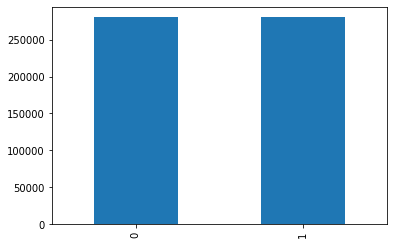

In [30]:
ax=yelp_reviews_df.Score.value_counts().plot(kind='bar')
fig = ax.get_figure()

In [31]:
yelp_reviews_df.head()

,Text,Score
0,unfortunately frustration dr. goldberg patient...,0
1,dr. goldberg 10 year think 1st patient start m...,1
2,know dr. goldberg like arizona let tell stay a...,0
3,write review head doctor office staff administ...,0
4,food great good thing wing wing simply fantast...,1


## More verification and preprocessing

- Taken from Sessions 1-3 from [yasheshshroff-labs-notebooks](https://github.com/yasheshshroff/NLPworkshop/tree/main/labs)

In [32]:
train_pos_df=yelp_reviews_df[yelp_reviews_df.Score==1][:125000]
train_neg_df=yelp_reviews_df[yelp_reviews_df.Score==0][:125000]

train_df=train_pos_df.append(train_neg_df)
train_df.shape

(250000, 2)

Let's parse a review and go thru the SpaCy exercises to verify any future processing will be ok

In [33]:
sample_review = yelp_reviews_df.Text[40]
sample_review

"okay hopefully enjoy happy hour riley pour house read able follow lilting irish owner recap murphy pour house 1979 1985 sullivan pour house 1995 2002 paddy pour house 2002 2012 bagpipe riley pour house open march 1 2012 tiny long bar like old irish pub smoking allow hurrah lousy service guess entire place need strike .... demand automate food beverage ticketing system cook bartender waitress know order ticket belong table actually pretty funny hungry b thirsty want place need irish pub local old time water hole murphy ... er mean sullivan's .... er mean paddy riley case cold guinness irish music fun patron"

In [34]:
sample_review = yelp_reviews_df.Text[90]
sample_review

'starbucks teeny tiny seating inside limited starbucks grab continue shopping waterfront baristas friendly fast'

In [35]:
parsed_review = nlp(sample_review)
parsed_review

for ent in parsed_review.ents:
  print(ent.text, ent.label_, ent.doc)

spacy.explain('ORG')

'Companies, agencies, institutions, etc.'

In [36]:
tokenized_text = pd.DataFrame()

for i, token in enumerate(parsed_review):
    tokenized_text.loc[i, 'text'] = token.text
    tokenized_text.loc[i, 'lemma'] = token.lemma_,
    tokenized_text.loc[i, 'pos'] = token.pos_
    tokenized_text.loc[i, 'tag'] = token.tag_
    tokenized_text.loc[i, 'dep'] = token.dep_
    tokenized_text.loc[i, 'shape'] = token.shape_
    tokenized_text.loc[i, 'is_alpha'] = token.is_alpha
    tokenized_text.loc[i, 'is_stop'] = token.is_stop
    tokenized_text.loc[i, 'is_punctuation'] = token.is_punct
    tokenized_text.loc[i, 'ent_id'] = token.ent_id

tokenized_text[:20]

,text,lemma,pos,tag,dep,shape,is_alpha,is_stop,is_punctuation,ent_id
0,starbucks,starbuck,VERB,VBZ,ROOT,xxxx,True,False,False,0.0
1,teeny,teeny,VERB,VBP,xcomp,xxxx,True,False,False,0.0
2,tiny,tiny,ADJ,JJ,amod,xxxx,True,False,False,0.0
3,seating,seating,NOUN,NN,dobj,xxxx,True,False,False,0.0
4,inside,inside,ADP,IN,prep,xxxx,True,False,False,0.0
5,limited,limited,ADJ,JJ,amod,xxxx,True,False,False,0.0
6,starbucks,starbuck,NOUN,NNS,compound,xxxx,True,False,False,0.0
7,grab,grab,NOUN,NN,pobj,xxxx,True,False,False,0.0
8,continue,continue,VERB,VBP,conj,xxxx,True,False,False,0.0
9,shopping,shopping,NOUN,NN,compound,xxxx,True,False,False,0.0


In [37]:
from spacy import displacy

displacy.render(parsed_review, style='ent', jupyter=True)

/home/garza/.local/lib/python3.7/site-packages/spacy/displacy/__init__.py:189: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  warnings.warn(Warnings.W006)


Dependency parsing
Identifies sentences, assigning a syntactic structure to it (subject-object)

In [38]:
sentence_spans = list(parsed_review.sents)
sentence_spans

[starbucks teeny tiny seating inside limited starbucks grab continue shopping waterfront baristas,
 friendly fast]

In [39]:
options = {'compact': True, 'bg': 'white','distance': 80,
           'color': 'green', 'font': 'Arial'}
displacy.render(parsed_review, jupyter=True, style='dep', options=options)

## Processing noun chunks 

The dependency parser adds the `token.dep` and `token.head` attributes
Further, it is also responsible for **noun chunks**: detecting sentences and base noun phrases

In [40]:
noun_chunks_df = pd.DataFrame()

for i, chunk in enumerate(parsed_review.noun_chunks):
    noun_chunks_df.loc[i, 'text'] = chunk.text
    noun_chunks_df.loc[i, 'root'] = chunk.root,
    noun_chunks_df.loc[i, 'root.text'] = chunk.root.text,
    noun_chunks_df.loc[i, 'root.dep_'] = chunk.root.dep_
    noun_chunks_df.loc[i, 'root.head.text'] = chunk.root.head.text

noun_chunks_df[:20]

,text,root,root.text,root.dep_,root.head.text
0,tiny seating,seating,seating,dobj,teeny
1,limited starbucks grab,"(grab,)","(grab,)",pobj,inside
2,shopping waterfront,"(waterfront,)","(waterfront,)",nsubj,baristas


In [8]:
!ls

01-clean-data.ipynb		      evaluate
02-prepare-spacy-docs.ipynb	      models
03-build-model-basic.ipynb	      scratch-testing.ipynb
04-build-model-TextCatBOW.ipynb       test-scores.png
05-build-model-TextCatCNN.ipynb       train-scores.png
06-build-model-TextCatEnsemble.ipynb  yelp_review_polarity_csv
07-evaluate-review.ipynb	      yelp_review_polarity_csv.tgz
config				      yelp_test_df.csv
data				      yelp_train_df.csv
